# MLP class

In [254]:
import numpy as np
from sklearn.metrics import f1_score

In [328]:
import copy

class MLP:
    def __init__(self, layer_sizes, act_fun='sigmoid', out_act_fun_name = 'linear', loss_fun_name = 'mse', metric = 'mse'):
        self.layer_sizes = layer_sizes
        self.n_layers = len(layer_sizes)
        self.set_act_fun(act_fun)
        self.set_out_act_fun(out_act_fun_name)
        self.set_loss_fun(loss_fun_name)
        self.metric = metric
        
        self.weights = [None] * (self.n_layers - 1)
        self.biases = [None] * (self.n_layers - 1)
        self.initialize_weights()

    def initialize_weights(self):
        for i in range(self.n_layers - 1):
            self.weights[i] = np.random.rand(self.layer_sizes[i], self.layer_sizes[i + 1])
            self.biases[i] = np.random.rand(self.layer_sizes[i + 1], 1)        

    def _forward(self, X, return_activations = False, return_probabilities = True):
        X = np.atleast_2d(X)
        if X.shape[0] == 1:
            X = X.reshape(-1, 1)
        Y = X
        if return_activations: A = []

        for i in range(self.n_layers - 2):
            Y = np.dot(Y, self.weights[i]) + self.biases[i].T
            if return_activations:
                A.append(Y)
            Y = self.act_fun(Y)
        Y = np.dot(Y, self.weights[-1]) + self.biases[-1].T
        if return_activations:
            A.append(Y)
        Y = self.out_act_fun(Y)
        if not return_probabilities and self.out_act_fun_name == 'softmax':
            Y = np.argmax(Y, axis=1)
        return Y if not return_activations else (Y, A)

    def predict(self, X, return_probabilities=True):
        return self._forward(X, return_probabilities=return_probabilities)
    
    def _backward(self, X, Y, batch_size):
        Y = np.atleast_2d(Y)
        X = np.atleast_2d(X)
        if X.shape[0] == 1:
            X = X.reshape(-1, 1)
        if Y.shape[0] == 1:
            Y = Y.reshape(-1, 1)
        Y_pred, A = self._forward(X, return_activations = True)
        error = Y_pred - Y
        D_weights = []
        D_biases = []
        E = np.array([])
        for i in range(len(self.weights) - 1, -1, -1):
            if i == len(self.weights) - 1:
                if self.loss_fun_name == 'cross_entropy' and self.out_act_fun_name == 'softmax':
                    E = error
                elif self.loss_fun_name == 'mse':
                    E = error * self.out_act_fun_prime(A[i])
            else:
                E = np.dot(E, self.weights[i + 1].T) * self.act_fun_prime(A[i])
            D_weights.insert(0, np.dot(self.act_fun(A[i - 1]).T, E) / batch_size if i > 0 else np.dot(X.T, E) / batch_size)
            D_biases.insert(0, np.sum(E, axis=0).reshape(-1, 1) / batch_size)
        return D_weights, D_biases
        

    def _momentum_update(self, D_weights, D_biases, momentum_coef, momentum_w, momentum_b, learning_rate):
        for i in range(len(self.weights)):
            momentum_w[i] = - D_weights[i] + momentum_coef * momentum_w[i]
            momentum_b[i] = - D_biases[i] + momentum_coef * momentum_b[i]
            self.weights[i] += learning_rate * momentum_w[i]
            self.biases[i] += learning_rate * momentum_b[i]
        return momentum_w, momentum_b
    
    def _RMSProp_update(self, D_weights, D_biases, beta, epsilon, E_w, E_b, learning_rate):
        for i in range(len(self.weights)):
            E_w[i] = beta * E_w[i] + (1 - beta) * D_weights[i] ** 2
            E_b[i] = beta * E_b[i] + (1 - beta) * D_biases[i] ** 2
            self.weights[i] -= learning_rate * D_weights[i] / (np.sqrt(E_w[i] + epsilon))
            self.biases[i] -= learning_rate * D_biases[i] / (np.sqrt(E_b[i] + epsilon))
        return E_w, E_b
    
    def fit(self, X_train, Y_train, X_val=None, Y_val=None, first_lr = 0.01, lr_decay_rate=0, momentum_coef=0.9, 
            epochs = 100, n_epochs_displayed = 100, optimizer=None, beta=0.9, epsilon=1e-8, track_weights=False, 
            track_validation=False,batch_size=32, return_metrics=False, l2_reg_coef=0, patience=0, stopping_min_coef=0.01):
        X_train = np.array(X_train)
        Y_train = np.array(Y_train)
        losses = [self.loss_fun(Y_train, self.predict(X_train))]

        if patience > 0:
            track_validation = True
            # track_weights = True

        if track_validation:
            val_losses = [self.loss_fun(Y_val, self.predict(X_val))]
            if patience > 0:
                min_val_loss = val_losses[-1]
                patience_counter = 0
                best_weights = copy.deepcopy(self.weights)
                best_biases = copy.deepcopy(self.biases)
                
        if return_metrics:
            metrics = [self.metric(Y_train, self.predict(X_train))]
            if track_validation:
                val_metrics = [self.metric(Y_val, self.predict(X_val))]
        if track_weights:
            weights_over_epochs = [copy.deepcopy(self.weights)]
            biases_over_epochs = [copy.deepcopy(self.biases)]
            
        if optimizer == 'momentum':
            momentum_w = [np.zeros(w.shape) for w in self.weights]
            momentum_b = [np.zeros(b.shape) for b in self.biases]

        if optimizer == 'RMSProp':
            E_w = [np.zeros(w.shape) for w in self.weights]
            E_b = [np.zeros(b.shape) for b in self.biases]

        if l2_reg_coef > 0:
            number_of_weights = np.sum([np.prod(w.shape) for w in self.weights])

        for epoch in range(epochs):
            permutaion = np.random.permutation(X_train.shape[0])
            learning_rate = first_lr / (1 + epoch * lr_decay_rate)
            for i in range(0, X_train.shape[0], batch_size):
                D_weights, D_biases = self._backward(X_train[permutaion[i:i + batch_size]], Y_train[permutaion[i:i + batch_size]], batch_size)
                if l2_reg_coef > 0:
                    for j in range(len(self.weights)):
                        D_weights[j] += l2_reg_coef * self.weights[j] / number_of_weights

                if not optimizer:
                    for j in range(len(self.weights)):
                        self.weights[j] -= learning_rate * D_weights[j]
                        self.biases[j] -= learning_rate * D_biases[j]
                elif optimizer == 'momentum':
                    momentum_w, momentum_b = self._momentum_update(D_weights, D_biases, momentum_coef, momentum_w, momentum_b, learning_rate)
                elif optimizer == 'RMSProp':
                    E_w, E_b = self._RMSProp_update(D_weights, D_biases, beta, epsilon, E_w, E_b, learning_rate)

            Y_pred = self.predict(X_train)
            losses.append(self.loss_fun(Y_train, Y_pred))
            if track_validation:
                val_losses.append(self.loss_fun(Y_val, self.predict(X_val)))
            if return_metrics:
                if self.metric == 'f1':
                    metrics.append(f1_score(np.argmax(Y_train, axis=1), np.argmax(Y_pred, axis=1), average="macro"))
                    if track_validation:
                        val_metrics.append(f1_score(np.argmax(Y_val, axis=1), np.argmax(self.predict(X_val), axis=1), average="macro"))
            if track_weights:
                weights_over_epochs.append(copy.deepcopy(self.weights))
                biases_over_epochs.append(copy.deepcopy(self.biases))
            
            if epoch == 0 or (epoch + 1) % n_epochs_displayed == 0:
                if self.metric == 'mse':
                    print(f'Epoch {epoch + 1}: loss_fun={losses[-1]}')
                elif self.metric == 'f1':
                    print(f'Epoch {epoch + 1}: loss_fun={losses[-1]}, f1_score={f1_score(np.argmax(Y_train, axis=1), np.argmax(Y_pred, axis=1), average="macro")}')
            
            if patience > 0:
                if val_losses[-1] < min_val_loss:
                    min_val_loss = val_losses[-1]
                    patience_counter = 0
                    best_weights = copy.deepcopy(self.weights)
                    best_biases = copy.deepcopy(self.biases)
                else:
                    if (1 + stopping_min_coef) * min_val_loss < val_losses[-1]:
                        patience_counter += 1
                    if patience_counter >= patience:
                        print(f'Early stopping at epoch {epoch + 1}')
                        self.weights = best_weights
                        self.biases = best_biases
                        break
        
        if track_weights and return_metrics:
            if track_validation:
                return losses, val_losses, metrics, val_metrics, weights_over_epochs, biases_over_epochs
            return losses, metrics, weights_over_epochs, biases_over_epochs
        elif track_weights:
            if track_validation:
                return losses, val_losses, weights_over_epochs, biases_over_epochs
            return losses, weights_over_epochs, biases_over_epochs
        elif return_metrics:
            if track_validation:
                return losses, val_losses, metrics, val_metrics
            return losses, metrics
        else:
            if track_validation:
                return losses, val_losses
            return losses
                
    def set_all_weights(self, weights):
        self.weights = weights

    def set_weights_for_layer(self, layer, weights):
        self.weights[layer] = weights

    def set_weigth(self, layer, from_neuron, to_neuron, value):
        self.weights[layer][from_neuron][to_neuron] = value

    def set_all_biases(self, biases):
        self.biases = biases

    def set_biases_for_layer(self, layer, biases):
        self.biases[layer] = biases

    def set_bias(self, layer, neuron, value):
        self.biases[layer][neuron] = value

    def set_act_fun(self, act_fun):
        act_fun_prime = None
        if act_fun == 'sigmoid':
            act_fun = lambda x: 1 / (1 + np.exp(-x))
            act_fun_prime = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

        if act_fun == 'relu':
            act_fun = lambda x: np.maximum(0, x)
            act_fun_prime = lambda x: np.where(x > 0, 1, 0)

        if act_fun == 'tanh':
            act_fun = lambda x: np.tanh(x)
            act_fun_prime = lambda x: 1 - np.tanh(x) ** 2

        if act_fun == 'linear':
            act_fun = lambda x: x
            act_fun_prime = lambda x: np.ones_like(x)
            
        self.act_fun = act_fun
        self.act_fun_prime = act_fun_prime

    def set_out_act_fun(self, out_act_fun_name):
        if not out_act_fun_name:
            out_act_fun_name = 'linear'
        if out_act_fun_name == 'linear':
            out_act_fun = lambda x: x
            out_act_fun_prime = lambda x: np.ones_like(x)
        elif out_act_fun_name == 'softmax':
            out_act_fun = lambda x: np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
            out_act_fun_prime = lambda x: np.exp(x) * (1 - np.exp(x)) / np.sum(np.exp(x), axis=1, keepdims=True) ** 2
        self.out_act_fun_name = out_act_fun_name
        self.out_act_fun = out_act_fun
        self.out_act_fun_prime = out_act_fun_prime

    def set_loss_fun(self, loss_fun_name):
        self.loss_fun_name = loss_fun_name
        def _mse(y, y_pred):
            y = np.atleast_2d(y)
            y_pred = np.atleast_2d(y_pred)
            if y.shape[0] == 1:
                y = y.reshape(-1, 1)
            if y_pred.shape[0] == 1:
                y_pred = y_pred.reshape(-1, 1)
            return np.mean((y - y_pred) ** 2) / 2
        
        def _cross_entropy(y, y_pred):
            y = np.atleast_2d(y)
            y_pred = np.atleast_2d(y_pred)
            if y.shape[0] == 1:
                y = y.reshape(-1, 1)
            if y_pred.shape[0] == 1:
                y_pred = y_pred.reshape(-1, 1)
            return -np.mean(np.sum(y * np.log(y_pred + 1e-15), axis=1))
        
        if loss_fun_name == 'mse':
            self.loss_fun = lambda y, y_pred: _mse(y, y_pred)
            self.loss_fun_prime = lambda y, y_pred: y_pred - y
        elif loss_fun_name == 'cross_entropy':
            self.loss_fun = lambda y, y_pred: _cross_entropy(y, y_pred)
            self.loss_fun_prime = lambda y, y_pred: - (y / (y_pred + 1e-15)) / y.shape[0]
    

    

    

In [256]:
def normalize(data, min = None, max = None):
    data = np.array(data)
    if min is None:
        min = np.min(data, axis=0)

    if max is None:
        max = np.max(data, axis=0)

    return (data - min) / (max - min), min, max    

In [257]:
def denormalize(data, min, max):
    data = np.array(data)
    return data * (max - min) + min

# Functions for visualisation

In [258]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [291]:
def plot_results(model, X_train, Y_train, X_test, Y_Test):
    X_train_norm, X_train_min, X_train_max = normalize(X_train)
    X_test_norm, _, _ = normalize(X_test, X_train_min, X_train_max)
    
    if model.loss_fun_name == 'mse':
        Y_train_norm, Y_train_min, Y_train_max = normalize(Y_train)

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].scatter(X_train, Y_train, label='Real values')
        ax[0].scatter(X_train, denormalize(model.predict(X_train_norm), Y_train_min, Y_train_max), label='Predicted values')
        ax[0].set_title('Train set')
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('y')
        ax[0].legend()

        ax[1].scatter(X_test, Y_Test, label='Real values')
        ax[1].scatter(X_test, denormalize(model.predict(X_test_norm), Y_train_min, Y_train_max), label='Predicted values')
        ax[1].set_title('Test set')
        ax[1].set_xlabel('x')
        ax[1].set_ylabel('y')
        ax[1].legend()
        plt.show()
    else:
        fig, ax = plt.subplots(2, 2, figsize=(12, 12))
        ax[0, 0].scatter(X_train['x'], X_train['y'], c=Y_train, cmap='viridis')
        ax[0, 0].set_title('Train set')
        ax[0, 0].set_xlabel('x')
        ax[0, 0].set_ylabel('y')
        
        ax[0, 1].scatter(X_train['x'], X_train['y'], c=model.predict(X_train_norm, return_probabilities=False), cmap='viridis')
        ax[0, 1].set_title('Train set predictions')
        ax[0, 1].set_xlabel('x')
        ax[0, 1].set_ylabel('y')
        
        ax[1, 0].scatter(X_test['x'], X_test['y'], c=Y_Test, cmap='viridis')
        ax[1, 0].set_title('Test set')
        ax[1, 0].set_xlabel('x')
        ax[1, 0].set_ylabel('y')

        ax[1, 1].scatter(X_test['x'], X_test['y'], c=model.predict(X_test_norm, return_probabilities=False), cmap='viridis')
        ax[1, 1].set_title('Test set predictions')
        ax[1, 1].set_xlabel('x')
        ax[1, 1].set_ylabel('y')

        plt.show()    

In [260]:
def compare_losses(standard_losses, standard_val_losses, l2_losses, l2_val_losses, stop_losses, stop_val_losses, scale_y_log=False):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(standard_losses, label='Standard')
    ax[0].plot(l2_losses, label='L2 Regularization')
    ax[0].plot(stop_losses, label='Early Stopping')
    ax[0].set_title('Train Losses')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    if scale_y_log:
        ax[0].set_yscale('log')
        ax[0].set_ylabel('loss (log scale)')
    else:
        ax[0].set_ylabel('loss')

    ax[1].plot(standard_val_losses, label='Standard')
    ax[1].plot(l2_val_losses, label='L2 Regularization')
    ax[1].plot(stop_val_losses, label='Early Stopping')
    ax[1].set_title('Validation Losses')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')
    if scale_y_log:
        ax[1].set_yscale('log')
        ax[1].set_ylabel('loss (log scale)')
    else:
        ax[1].set_ylabel('loss')
    plt.show()


# multimodal-sparse

In [364]:
X_train = pd.read_csv('data/regression/multimodal-sparse-training.csv')['x']
Y_train = pd.read_csv('data/regression/multimodal-sparse-training.csv')['y']
X_test = pd.read_csv('data/regression/multimodal-sparse-test.csv')['x']
Y_test = pd.read_csv('data/regression/multimodal-sparse-test.csv')['y']

In [365]:
X_train_norm, X_train_min, X_train_max = normalize(X_train)
X_test_norm, _, _ = normalize(X_test, X_train_min, X_train_max)
Y_train_norm, Y_train_min, Y_train_max = normalize(Y_train)
Y_test_norm, _, _ = normalize(Y_test, Y_train_min, Y_train_max)

In [366]:
model_root = MLP([1, 10, 10, 10, 1], act_fun='sigmoid', out_act_fun_name='linear', loss_fun_name='mse', metric='mse')

In [370]:
epochs = 50000
n_epochs_displayed = 100
optimizer = None
first_lr = 0.1
batch_size = 1

## Standard model

Epoch 1: loss_fun=0.15588660017536032
Epoch 100: loss_fun=0.23158765315089255
Epoch 200: loss_fun=0.10623115587440553
Epoch 300: loss_fun=0.11708122520809619
Epoch 400: loss_fun=0.08671542400621526
Epoch 500: loss_fun=0.11534767440021679
Epoch 600: loss_fun=0.11812232485327549
Epoch 700: loss_fun=0.10906868070888101
Epoch 800: loss_fun=0.08994437055595764
Epoch 900: loss_fun=0.0718540845158762
Epoch 1000: loss_fun=0.08031766142021923
Epoch 1100: loss_fun=0.07705565149703605
Epoch 1200: loss_fun=0.08442383172993308
Epoch 1300: loss_fun=0.12236923845130596
Epoch 1400: loss_fun=0.10683388173930228
Epoch 1500: loss_fun=0.07222425909510091
Epoch 1600: loss_fun=0.08096234926614232
Epoch 1700: loss_fun=0.07464140682728349
Epoch 1800: loss_fun=0.07340059822732692
Epoch 1900: loss_fun=0.082675724665641
Epoch 2000: loss_fun=0.08304922870599481
Epoch 2100: loss_fun=0.09303339630017991
Epoch 2200: loss_fun=0.07349887552582397
Epoch 2300: loss_fun=0.07206341520821277
Epoch 2400: loss_fun=0.08099983

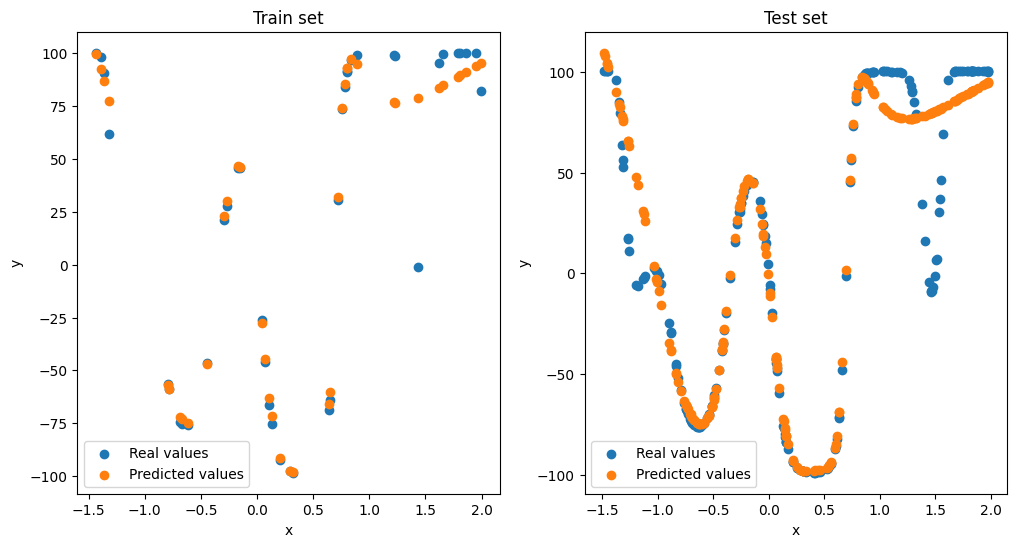

In [371]:
model_standard = copy.deepcopy(model_root)
standard_losses, standard_val_losses = model_standard.fit(X_train_norm, Y_train_norm, X_val=X_test_norm, Y_val=Y_test_norm, 
                                                          first_lr=first_lr, epochs=epochs, n_epochs_displayed=n_epochs_displayed, 
                                                          batch_size=batch_size, track_validation=True, optimizer=optimizer)
plot_results(model_standard, X_train, Y_train, X_test, Y_test)

## L2 regularization

Epoch 1: loss_fun=0.10816659902511258
Epoch 100: loss_fun=0.08217567184008719
Epoch 200: loss_fun=0.11376916088387592
Epoch 300: loss_fun=0.16194916749824478
Epoch 400: loss_fun=0.07977307837538722
Epoch 500: loss_fun=0.0779038122992527
Epoch 600: loss_fun=0.07291327357221669
Epoch 700: loss_fun=0.0763812165489423
Epoch 800: loss_fun=0.10941845490017339
Epoch 900: loss_fun=0.07253385092072437
Epoch 1000: loss_fun=0.07332345953282127
Epoch 1100: loss_fun=0.07609508594263034
Epoch 1200: loss_fun=0.07167824857226261
Epoch 1300: loss_fun=0.08342054508124792
Epoch 1400: loss_fun=0.07955000019630538
Epoch 1500: loss_fun=0.07400162962724767
Epoch 1600: loss_fun=0.08372326115432047
Epoch 1700: loss_fun=0.085728154410452
Epoch 1800: loss_fun=0.07289500824946936
Epoch 1900: loss_fun=0.07512790851669544
Epoch 2000: loss_fun=0.077034936697097
Epoch 2100: loss_fun=0.07228830635377936
Epoch 2200: loss_fun=0.07111449029982413
Epoch 2300: loss_fun=0.07595669375106959
Epoch 2400: loss_fun=0.07073642219

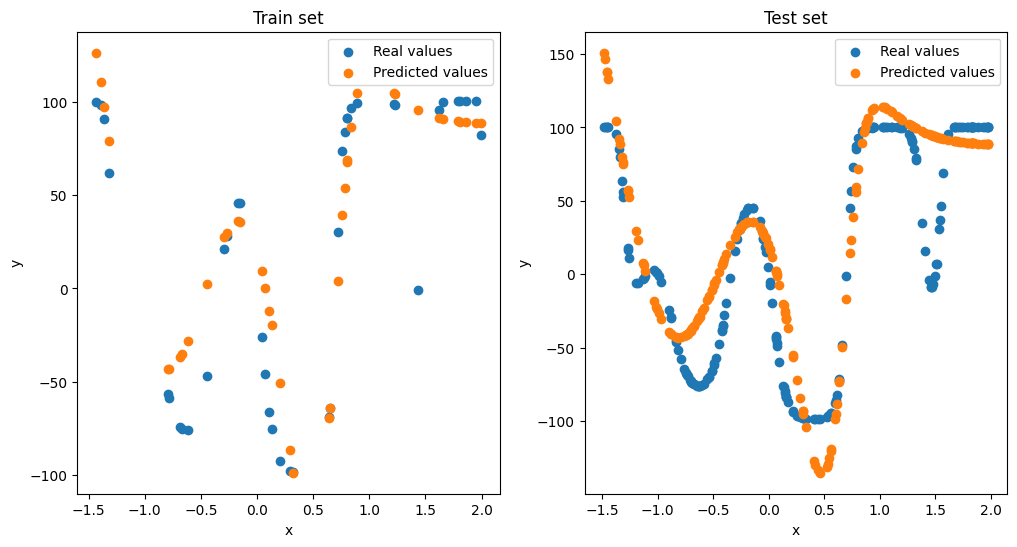

In [372]:
model_l2 = copy.deepcopy(model_root)
l2_losses, l2_val_losses = model_l2.fit(X_train_norm, Y_train_norm, X_val=X_test_norm, Y_val=Y_test_norm, 
                                        first_lr=first_lr, epochs=epochs, n_epochs_displayed=n_epochs_displayed, 
                                        batch_size=batch_size, track_validation=True, l2_reg_coef=0.01, optimizer=optimizer)
plot_results(model_l2, X_train, Y_train, X_test, Y_test)

## Early stopping

Epoch 1: loss_fun=0.23521147945189497
Epoch 100: loss_fun=0.0773584002088877
Epoch 200: loss_fun=0.20328195308186342
Epoch 300: loss_fun=0.08253164120518156
Epoch 400: loss_fun=0.13556211512333394
Epoch 500: loss_fun=0.08243716324063377
Epoch 600: loss_fun=0.11301909687946046
Epoch 700: loss_fun=0.0739185081728322
Epoch 800: loss_fun=0.09213135180833862
Epoch 900: loss_fun=0.07207435505452463
Epoch 1000: loss_fun=0.0729564159995127
Epoch 1100: loss_fun=0.07302556236026522
Epoch 1200: loss_fun=0.0747589411922543
Epoch 1300: loss_fun=0.07467793330377011
Epoch 1400: loss_fun=0.08886384965603486
Epoch 1500: loss_fun=0.081851245346787
Epoch 1600: loss_fun=0.07169342516843
Epoch 1700: loss_fun=0.07356886293312093
Epoch 1800: loss_fun=0.07235713843153477
Epoch 1900: loss_fun=0.08449161172518696
Epoch 2000: loss_fun=0.07231715141464716
Epoch 2100: loss_fun=0.08468972577545483
Epoch 2200: loss_fun=0.07509691179475657
Epoch 2300: loss_fun=0.0854695354349145
Epoch 2400: loss_fun=0.091672491214621

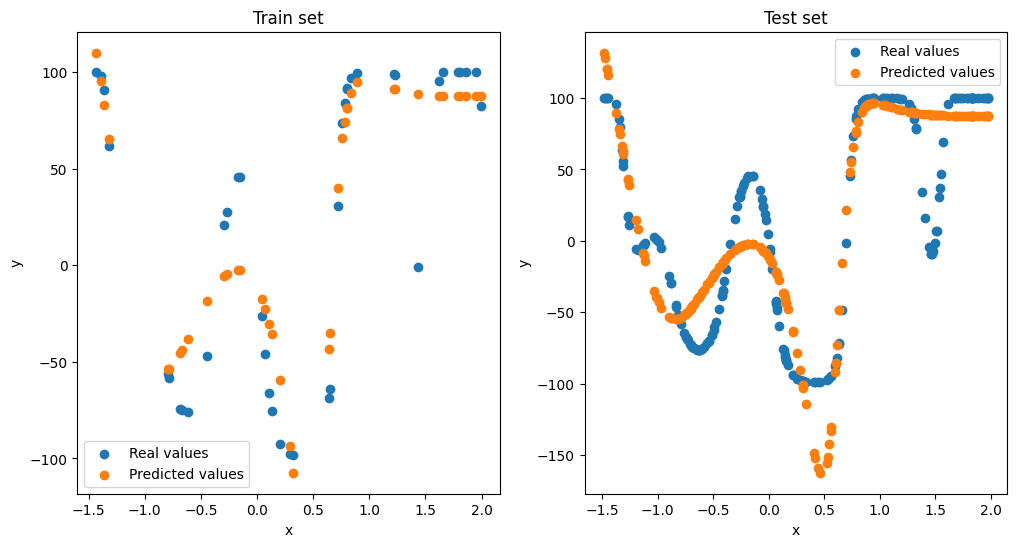

In [373]:
model_stop = copy.deepcopy(model_root)
stop_losses, stop_val_losses = model_stop.fit(X_train_norm, Y_train_norm, X_val=X_test_norm, Y_val=Y_test_norm, 
                                                first_lr=first_lr, epochs=epochs, n_epochs_displayed=n_epochs_displayed, 
                                                batch_size=batch_size, track_validation=True, optimizer=optimizer, patience=1000, stopping_min_coef=0.1)
plot_results(model_stop, X_train, Y_train, X_test, Y_test)

## Loss function over epochs dynamic

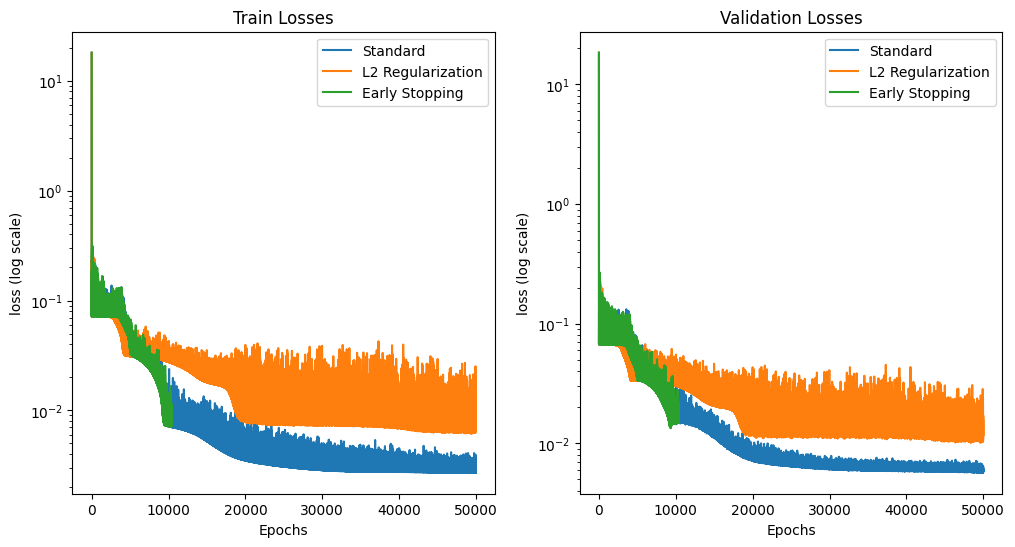

In [376]:
compare_losses(standard_losses, standard_val_losses, l2_losses, l2_val_losses, stop_losses, stop_val_losses, scale_y_log=True)

In [381]:
print('Standard model mse:', model_standard.loss_fun(Y_test_norm, model_standard.predict(X_test_norm)))
print('L2 model mse:', model_l2.loss_fun(Y_test_norm, model_l2.predict(X_test_norm)))
print('Early stopping model mse:', model_stop.loss_fun(Y_test_norm, model_stop.predict(X_test_norm)))

Standard model mse: 0.005924800319479518
L2 model mse: 0.01556251299613264
Early stopping model mse: 0.013409496280756801


# rings5-sparse

In [330]:
X_train = pd.read_csv('data/classification/rings5-sparse-training.csv')[['x', 'y']]
Y_train = pd.read_csv('data/classification/rings5-sparse-training.csv')['c']
X_test = pd.read_csv('data/classification/rings5-sparse-test.csv')[['x', 'y']]
Y_test = pd.read_csv('data/classification/rings5-sparse-test.csv')['c']

In [331]:
X_train_norm, X_train_min, X_train_max = normalize(X_train)
X_test_norm, _, _ = normalize(X_test, X_train_min, X_train_max)
Y_train_norm = pd.get_dummies(Y_train)
Y_test_norm = pd.get_dummies(Y_test)

In [332]:
model_root = MLP([2, 10, 10, 10, 5], act_fun='sigmoid', out_act_fun_name='softmax', loss_fun_name='cross_entropy', metric='f1')

In [333]:
epochs = 10000
n_epochs_displayed = 100
optimizer = None
first_lr = 0.1
batch_size = 5

## Standard model

Epoch 1: loss_fun=1.6599008845978176, f1_score=0.06666666666666667
Epoch 100: loss_fun=1.6649011342385547, f1_score=0.06666666666666667
Epoch 200: loss_fun=1.6590665048229472, f1_score=0.06666666666666667
Epoch 300: loss_fun=1.6465683448173618, f1_score=0.06666666666666667
Epoch 400: loss_fun=1.6509900694203907, f1_score=0.06666666666666667
Epoch 500: loss_fun=1.6356131605057098, f1_score=0.06666666666666667
Epoch 600: loss_fun=1.6151153412384065, f1_score=0.06666666666666667
Epoch 700: loss_fun=1.6144366170736186, f1_score=0.06666666666666667
Epoch 800: loss_fun=1.6213840072676446, f1_score=0.06666666666666667
Epoch 900: loss_fun=1.622986797368128, f1_score=0.06666666666666667
Epoch 1000: loss_fun=1.6165739018331893, f1_score=0.06666666666666667
Epoch 1100: loss_fun=1.6191781820715498, f1_score=0.06666666666666667
Epoch 1200: loss_fun=1.6115472541238134, f1_score=0.06666666666666667
Epoch 1300: loss_fun=1.6173282085796736, f1_score=0.06666666666666667
Epoch 1400: loss_fun=1.6144926172

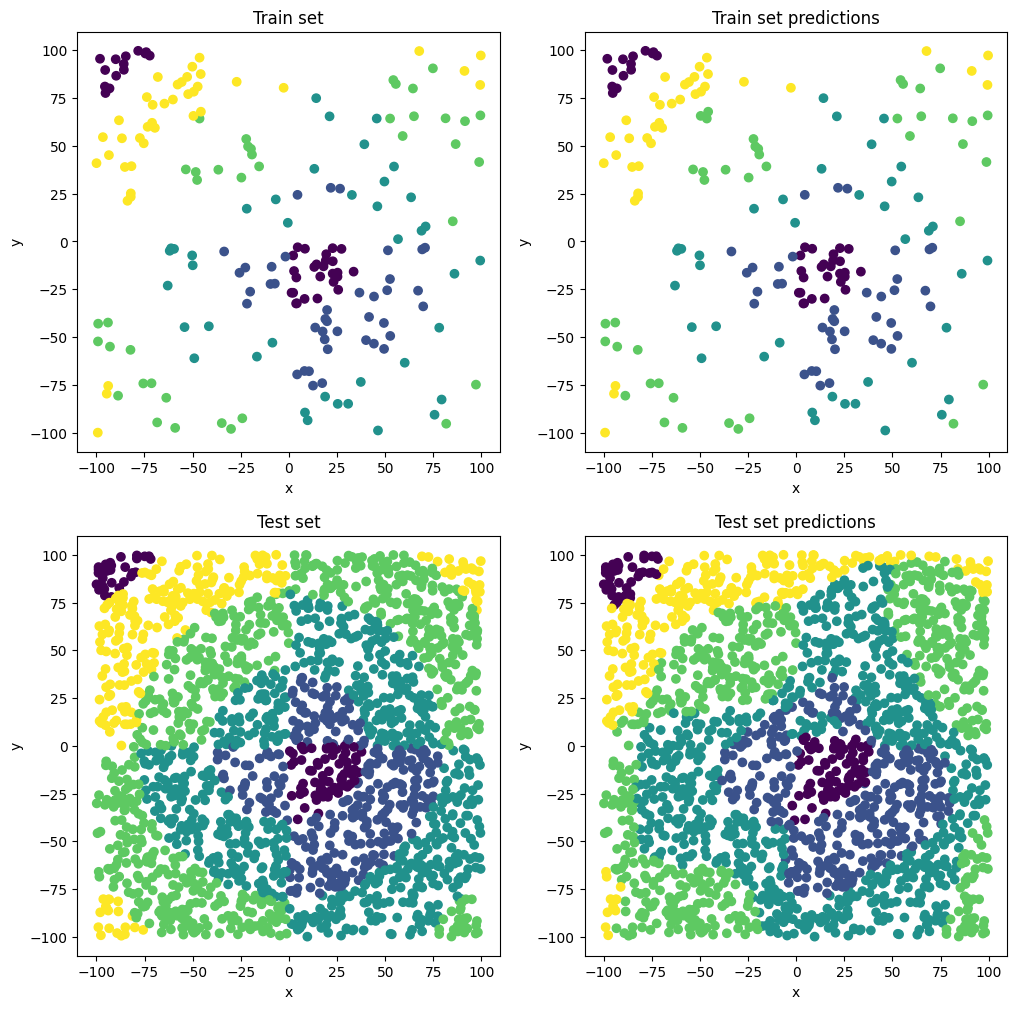

In [334]:
model_standard = copy.deepcopy(model_root)
standard_losses, standard_val_losses = model_standard.fit(X_train_norm, Y_train_norm, X_val=X_test_norm, Y_val=Y_test_norm, 
                                                          first_lr=first_lr, epochs=epochs, n_epochs_displayed=n_epochs_displayed, 
                                                          batch_size=batch_size, track_validation=True, optimizer=optimizer)
plot_results(model_standard, X_train, Y_train, X_test, Y_test)

## L2 regularization

Epoch 1: loss_fun=1.6514483638757336, f1_score=0.06666666666666667
Epoch 100: loss_fun=1.6307483780105476, f1_score=0.06666666666666667
Epoch 200: loss_fun=1.6197564258419517, f1_score=0.06666666666666667
Epoch 300: loss_fun=1.6124522455905896, f1_score=0.06666666666666667
Epoch 400: loss_fun=1.6145137740092803, f1_score=0.06666666666666667
Epoch 500: loss_fun=1.6097335940591797, f1_score=0.06666666666666667
Epoch 600: loss_fun=1.6095222971453784, f1_score=0.06666666666666667
Epoch 700: loss_fun=1.609524319021817, f1_score=0.06666666666666667
Epoch 800: loss_fun=1.6095890940965802, f1_score=0.06666666666666667
Epoch 900: loss_fun=1.609642339760022, f1_score=0.09396551724137932
Epoch 1000: loss_fun=1.6093672639030006, f1_score=0.06666666666666667
Epoch 1100: loss_fun=1.6096931229532316, f1_score=0.06666666666666667
Epoch 1200: loss_fun=1.6095508662025646, f1_score=0.06666666666666667
Epoch 1300: loss_fun=1.6092476615359101, f1_score=0.06666666666666667
Epoch 1400: loss_fun=1.61005511954

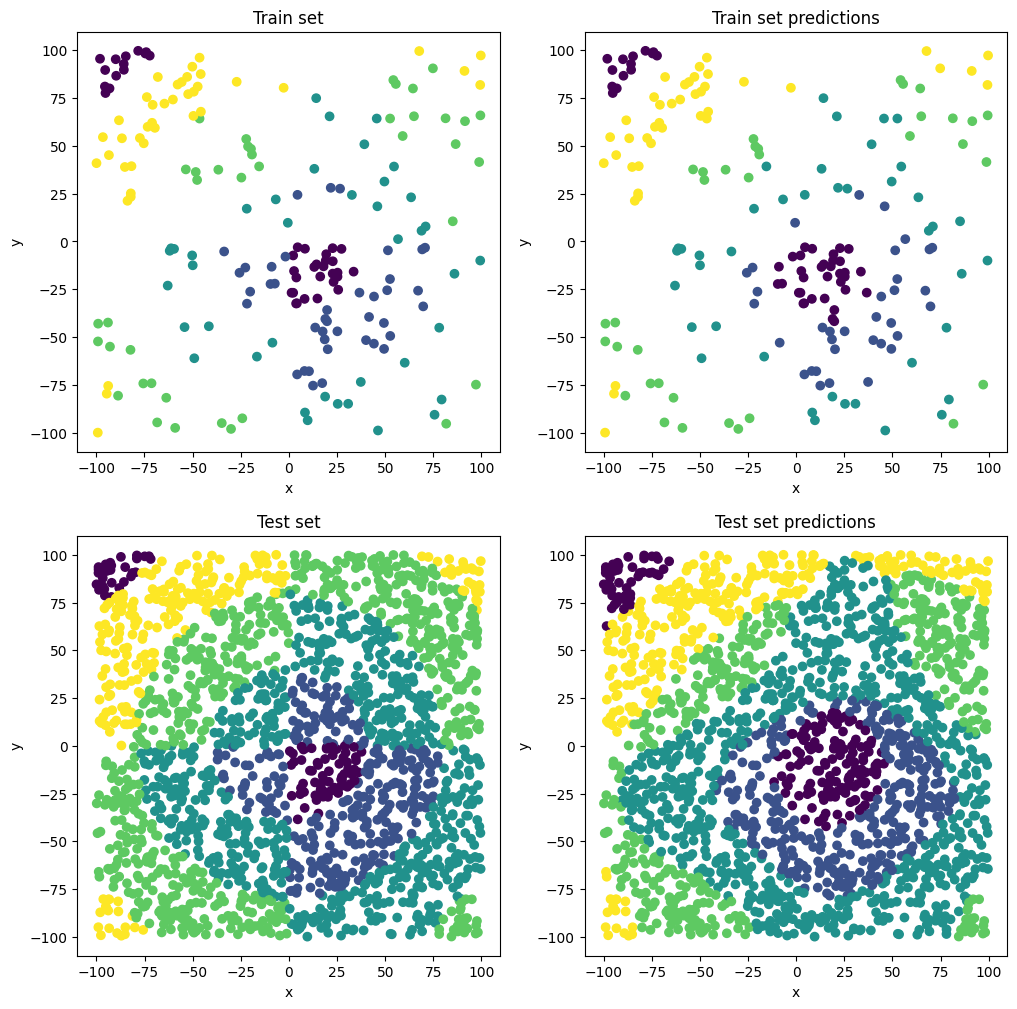

In [335]:
model_l2 = copy.deepcopy(model_root)
l2_losses, l2_val_losses = model_l2.fit(X_train_norm, Y_train_norm, X_val=X_test_norm, Y_val=Y_test_norm, 
                                        first_lr=first_lr, epochs=epochs, n_epochs_displayed=n_epochs_displayed, 
                                        batch_size=batch_size, track_validation=True, l2_reg_coef=0.1, optimizer=optimizer)
plot_results(model_l2, X_train, Y_train, X_test, Y_test)

## Early stopping

Epoch 1: loss_fun=1.6357877335267346, f1_score=0.06666666666666667
Epoch 100: loss_fun=1.6433609747731526, f1_score=0.06666666666666667
Epoch 200: loss_fun=1.6678920169137512, f1_score=0.06666666666666667
Epoch 300: loss_fun=1.6467338999719356, f1_score=0.06666666666666667
Epoch 400: loss_fun=1.615849708445355, f1_score=0.06666666666666667
Epoch 500: loss_fun=1.6181327867548527, f1_score=0.06666666666666667
Epoch 600: loss_fun=1.61709179200163, f1_score=0.06666666666666667
Epoch 700: loss_fun=1.6211675719801588, f1_score=0.06666666666666667
Epoch 800: loss_fun=1.6368734302661432, f1_score=0.06666666666666667
Epoch 900: loss_fun=1.6340703801790628, f1_score=0.06666666666666667
Epoch 1000: loss_fun=1.6204631074862406, f1_score=0.06666666666666667
Epoch 1100: loss_fun=1.612452964509025, f1_score=0.06666666666666667
Epoch 1200: loss_fun=1.6102265425839568, f1_score=0.06666666666666667
Epoch 1300: loss_fun=1.6241541463605567, f1_score=0.06666666666666667
Epoch 1400: loss_fun=1.6107197649250

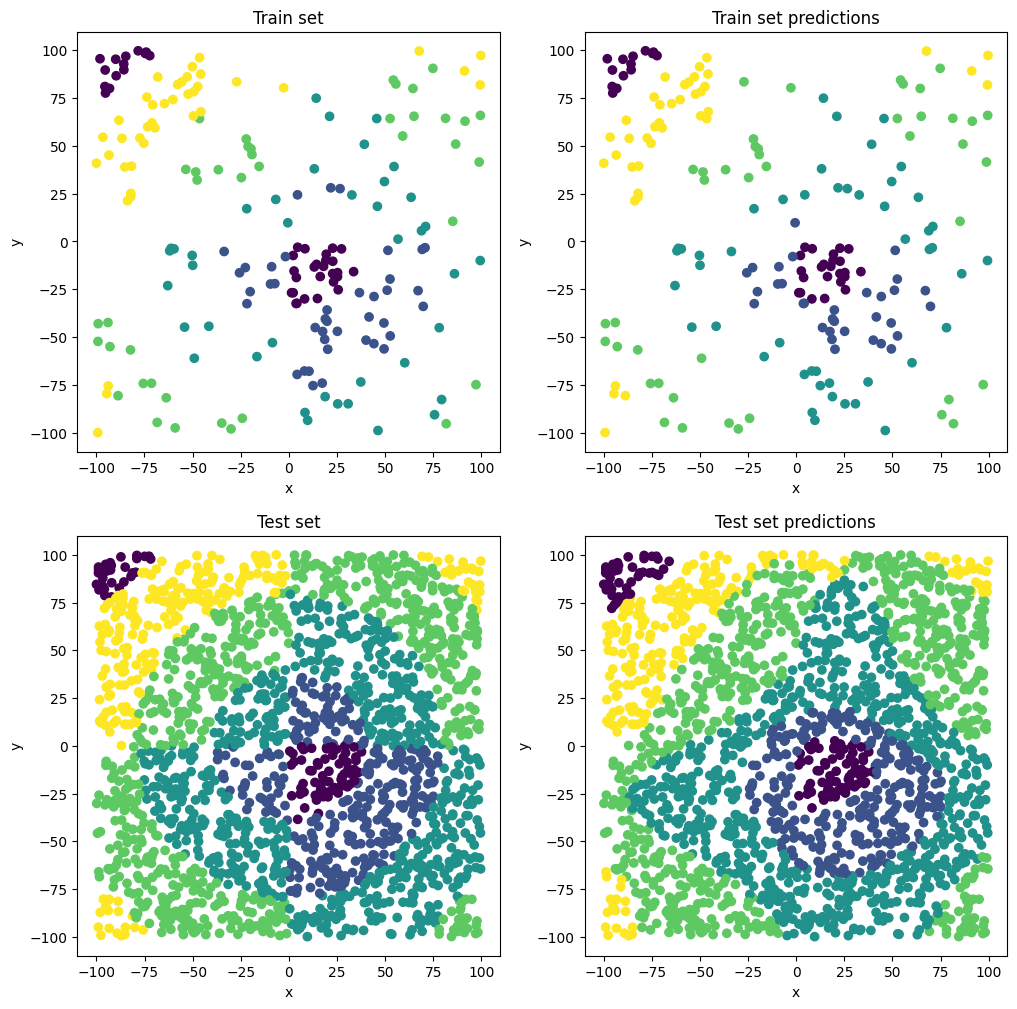

In [345]:
model_stop = copy.deepcopy(model_root)
stop_losses, stop_val_losses = model_stop.fit(X_train_norm, Y_train_norm, X_val=X_test_norm, Y_val=Y_test_norm, 
                                                first_lr=first_lr, epochs=epochs, n_epochs_displayed=n_epochs_displayed, 
                                                batch_size=batch_size, track_validation=True, optimizer=optimizer, patience=2500, stopping_min_coef=0.1)
plot_results(model_stop, X_train, Y_train, X_test, Y_test)

## Loss function over epochs dynamic

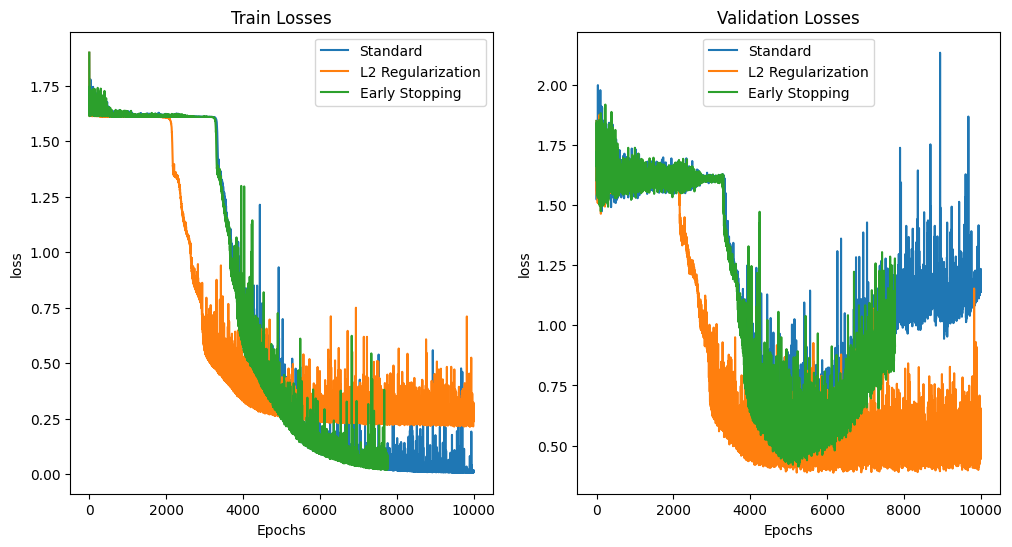

In [346]:
compare_losses(standard_losses, standard_val_losses, l2_losses, l2_val_losses, stop_losses, stop_val_losses, scale_y_log=False)

In [353]:
print('Standard model cross entropy:', model_standard.loss_fun(Y_test_norm, model_standard.predict(X_test_norm, return_probabilities=True)))
print('L2 model cross entropy:', model_l2.loss_fun(Y_test_norm, model_l2.predict(X_test_norm, return_probabilities=True)))
print('Early stopping model cross entropy:', model_stop.loss_fun(Y_test_norm, model_stop.predict(X_test_norm, return_probabilities=True)))
print()
print('Standard model f1 score:', f1_score(Y_test, model_standard.predict(X_test_norm, return_probabilities=False), average="macro"))
print('L2 model f1 score:', f1_score(Y_test, model_l2.predict(X_test_norm, return_probabilities=False), average="macro"))
print('Early stopping model f1 score:', f1_score(Y_test, model_stop.predict(X_test_norm, return_probabilities=False), average="macro"))

Standard model cross entropy: 1.1406285946797634
L2 model cross entropy: 0.5934548211326421
Early stopping model cross entropy: 0.4125250328149383

Standard model f1 score: 0.8236291322589029
L2 model f1 score: 0.72932612265691
Early stopping model f1 score: 0.8354885431775827


# rings3-balance

In [354]:
X_train = pd.read_csv('data/classification/rings3-balance-training.csv')[['x', 'y']]
Y_train = pd.read_csv('data/classification/rings3-balance-training.csv')['c']
X_test = pd.read_csv('data/classification/rings3-balance-test.csv')[['x', 'y']]
Y_test = pd.read_csv('data/classification/rings3-balance-test.csv')['c']

In [355]:
X_train_norm, X_train_min, X_train_max = normalize(X_train)
X_test_norm, _, _ = normalize(X_test, X_train_min, X_train_max)
Y_train_norm = pd.get_dummies(Y_train)
Y_test_norm = pd.get_dummies(Y_test)

In [356]:
model_root = MLP([2, 10, 10, 10, 3], act_fun='sigmoid', out_act_fun_name='softmax', loss_fun_name='cross_entropy', metric='f1')

In [357]:
epochs = 10000
n_epochs_displayed = 100
optimizer = None
first_lr = 0.1
batch_size = 32

## Standard model

Epoch 1: loss_fun=0.8095210821370209, f1_score=0.2178649237472767
Epoch 100: loss_fun=0.8084297854944198, f1_score=0.2178649237472767
Epoch 200: loss_fun=0.8052736455329206, f1_score=0.2178649237472767
Epoch 300: loss_fun=0.8049942670440582, f1_score=0.2178649237472767
Epoch 400: loss_fun=0.8103219140790031, f1_score=0.2178649237472767
Epoch 500: loss_fun=0.8115996062741448, f1_score=0.2178649237472767
Epoch 600: loss_fun=0.8057396550241821, f1_score=0.2178649237472767
Epoch 700: loss_fun=0.8087766231838421, f1_score=0.2178649237472767
Epoch 800: loss_fun=0.8034314500880224, f1_score=0.2178649237472767
Epoch 900: loss_fun=0.6512583197256818, f1_score=0.41634432768942364
Epoch 1000: loss_fun=0.6263434910041631, f1_score=0.4586634719463623
Epoch 1100: loss_fun=0.6181352539373823, f1_score=0.46760582027802267
Epoch 1200: loss_fun=0.6183556465030465, f1_score=0.46850435000585816
Epoch 1300: loss_fun=0.6118909241391299, f1_score=0.46902356902356906
Epoch 1400: loss_fun=0.6152311758263928, f

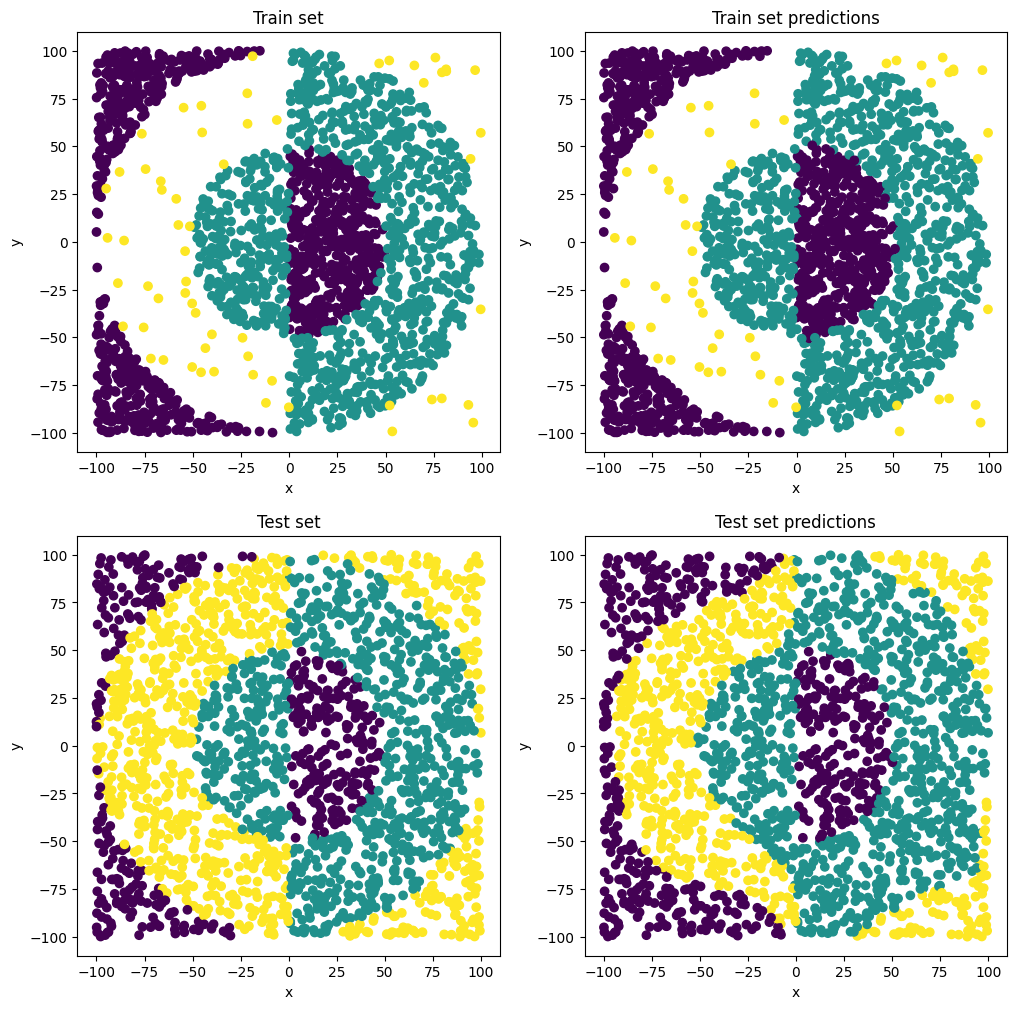

In [358]:
model_standard = copy.deepcopy(model_root)
standard_losses, standard_val_losses = model_standard.fit(X_train_norm, Y_train_norm, X_val=X_test_norm, Y_val=Y_test_norm, 
                                                          first_lr=first_lr, epochs=epochs, n_epochs_displayed=n_epochs_displayed, 
                                                          batch_size=batch_size, track_validation=True, optimizer=optimizer)
plot_results(model_standard, X_train, Y_train, X_test, Y_test)

## L2 regularization

Epoch 1: loss_fun=0.8057614489796622, f1_score=0.2178649237472767
Epoch 100: loss_fun=0.8058466160100874, f1_score=0.2178649237472767
Epoch 200: loss_fun=0.8049802830367186, f1_score=0.2178649237472767
Epoch 300: loss_fun=0.8117000997970402, f1_score=0.2178649237472767
Epoch 400: loss_fun=0.8055371774786908, f1_score=0.2178649237472767
Epoch 500: loss_fun=0.8047435384819573, f1_score=0.2178649237472767
Epoch 600: loss_fun=0.8068111936531428, f1_score=0.2178649237472767
Epoch 700: loss_fun=0.805994488242827, f1_score=0.2178649237472767
Epoch 800: loss_fun=0.8059521825122061, f1_score=0.2178649237472767
Epoch 900: loss_fun=0.8049366156796464, f1_score=0.2178649237472767
Epoch 1000: loss_fun=0.8078991292163872, f1_score=0.2178649237472767
Epoch 1100: loss_fun=0.8046556213163945, f1_score=0.2178649237472767
Epoch 1200: loss_fun=0.805167024761987, f1_score=0.2178649237472767
Epoch 1300: loss_fun=0.8073186622210117, f1_score=0.2178649237472767
Epoch 1400: loss_fun=0.8054344954345187, f1_scor

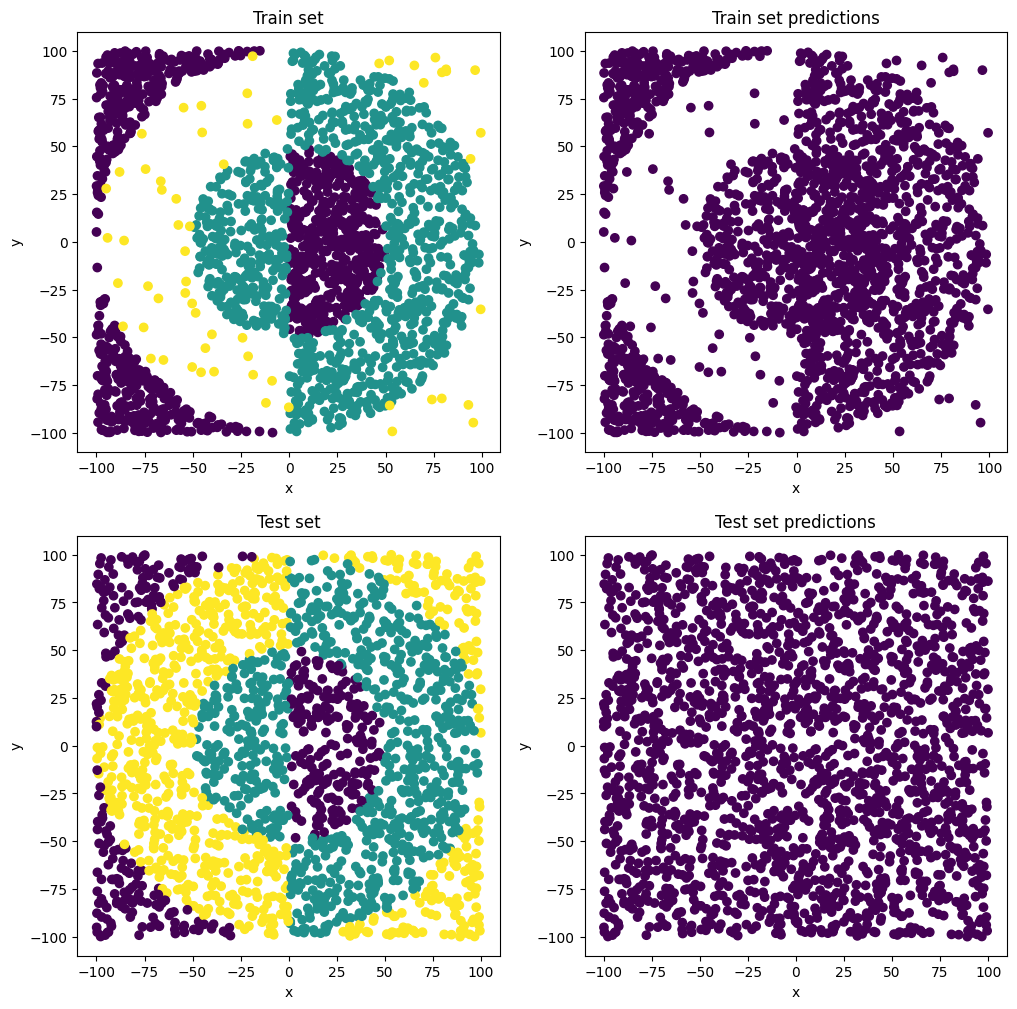

In [359]:
model_l2 = copy.deepcopy(model_root)
l2_losses, l2_val_losses = model_l2.fit(X_train_norm, Y_train_norm, X_val=X_test_norm, Y_val=Y_test_norm, 
                                        first_lr=first_lr, epochs=epochs, n_epochs_displayed=n_epochs_displayed, 
                                        batch_size=batch_size, track_validation=True, l2_reg_coef=0.1, optimizer=optimizer)
plot_results(model_l2, X_train, Y_train, X_test, Y_test)

## Early stopping

Epoch 1: loss_fun=0.805312132602681, f1_score=0.2178649237472767
Epoch 100: loss_fun=0.8047449657461546, f1_score=0.2178649237472767
Epoch 200: loss_fun=0.8093064740726528, f1_score=0.2178649237472767
Epoch 300: loss_fun=0.8056381424629588, f1_score=0.2178649237472767
Epoch 400: loss_fun=0.809339005641788, f1_score=0.2178649237472767
Epoch 500: loss_fun=0.8055576671270019, f1_score=0.2178649237472767
Epoch 600: loss_fun=0.8049128374583041, f1_score=0.2178649237472767
Epoch 700: loss_fun=0.8069317849151931, f1_score=0.2178649237472767
Epoch 800: loss_fun=0.8036589462486341, f1_score=0.2178649237472767
Epoch 900: loss_fun=0.6514823622139231, f1_score=0.4148267343176632
Epoch 1000: loss_fun=0.6295549540120697, f1_score=0.45311135719069
Epoch 1100: loss_fun=0.6184103210624612, f1_score=0.46560164013271055
Epoch 1200: loss_fun=0.6142570985707413, f1_score=0.46831747949066377
Epoch 1300: loss_fun=0.6100200035044379, f1_score=0.47005478879140866
Epoch 1400: loss_fun=0.6049222095328081, f1_sco

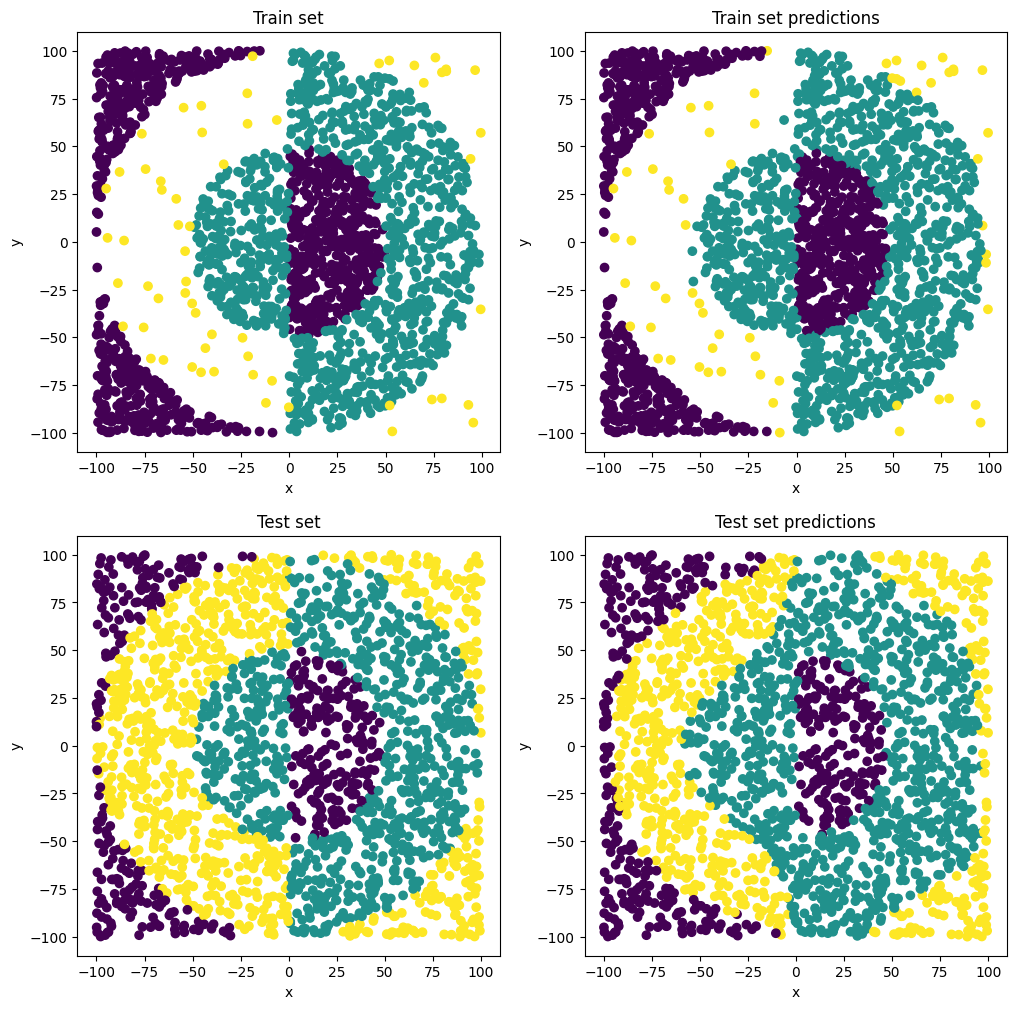

In [360]:
model_stop = copy.deepcopy(model_root)
stop_losses, stop_val_losses = model_stop.fit(X_train_norm, Y_train_norm, X_val=X_test_norm, Y_val=Y_test_norm, 
                                                first_lr=first_lr, epochs=epochs, n_epochs_displayed=n_epochs_displayed, 
                                                batch_size=batch_size, track_validation=True, optimizer=optimizer, patience=500, stopping_min_coef=0.1)
plot_results(model_stop, X_train, Y_train, X_test, Y_test)

## Loss function over epochs dynamic

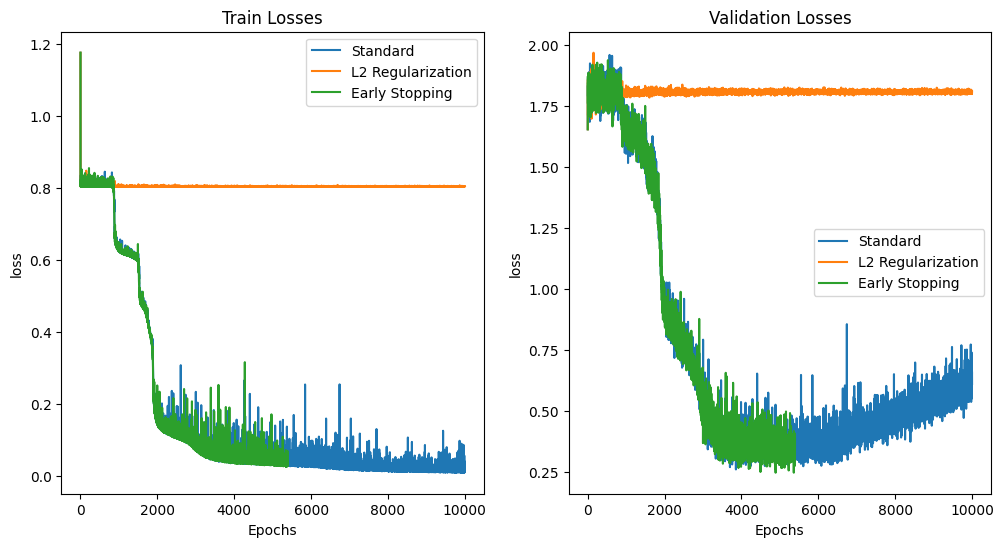

In [363]:
compare_losses(standard_losses, standard_val_losses, l2_losses, l2_val_losses, stop_losses, stop_val_losses, scale_y_log=False)

In [362]:
print('Standard model cross entropy:', model_standard.loss_fun(Y_test_norm, model_standard.predict(X_test_norm, return_probabilities=True)))
print('L2 model cross entropy:', model_l2.loss_fun(Y_test_norm, model_l2.predict(X_test_norm, return_probabilities=True)))
print('Early stopping model cross entropy:', model_stop.loss_fun(Y_test_norm, model_stop.predict(X_test_norm, return_probabilities=True)))
print()
print('Standard model f1 score:', f1_score(Y_test, model_standard.predict(X_test_norm, return_probabilities=False), average="macro"))
print('L2 model f1 score:', f1_score(Y_test, model_l2.predict(X_test_norm, return_probabilities=False), average="macro"))
print('Early stopping model f1 score:', f1_score(Y_test, model_stop.predict(X_test_norm, return_probabilities=False), average="macro"))

Standard model cross entropy: 0.6118808892825518
L2 model cross entropy: 1.8092443576209427
Early stopping model cross entropy: 0.24816802171406657

Standard model f1 score: 0.890148972570159
L2 model f1 score: 0.1170651277823578
Early stopping model f1 score: 0.9073295882300968


# xor3-balance

In [402]:
X_train = pd.read_csv('data/classification/xor3-balance-training.csv')[['x', 'y']]
Y_train = pd.read_csv('data/classification/xor3-balance-training.csv')['c']
X_test = pd.read_csv('data/classification/xor3-balance-test.csv')[['x', 'y']]
Y_test = pd.read_csv('data/classification/xor3-balance-test.csv')['c']

In [403]:
X_train_norm, X_train_min, X_train_max = normalize(X_train)
X_test_norm, _, _ = normalize(X_test, X_train_min, X_train_max)
Y_train_norm = pd.get_dummies(Y_train)
Y_test_norm = pd.get_dummies(Y_test)

In [404]:
model_root = MLP([2, 10, 10, 10, 2], act_fun='sigmoid', out_act_fun_name='softmax', loss_fun_name='cross_entropy', metric='f1')

In [405]:
epochs = 10000
n_epochs_displayed = 100
optimizer = None
first_lr = 0.1
batch_size = 32

## Standard model

Epoch 1: loss_fun=0.19150191051887896, f1_score=0.4878048780487805
Epoch 100: loss_fun=0.19147872094344046, f1_score=0.4878048780487805
Epoch 200: loss_fun=0.1914912453834471, f1_score=0.4878048780487805
Epoch 300: loss_fun=0.1929330013717752, f1_score=0.4878048780487805
Epoch 400: loss_fun=0.19145032484675664, f1_score=0.4878048780487805
Epoch 500: loss_fun=0.19171856063963405, f1_score=0.4878048780487805
Epoch 600: loss_fun=0.19148814344692175, f1_score=0.4878048780487805
Epoch 700: loss_fun=0.19159577058709606, f1_score=0.4878048780487805
Epoch 800: loss_fun=0.19148817673649843, f1_score=0.4878048780487805
Epoch 900: loss_fun=0.19312995330484248, f1_score=0.4878048780487805
Epoch 1000: loss_fun=0.19170772148098647, f1_score=0.4878048780487805
Epoch 1100: loss_fun=0.1914605895353481, f1_score=0.4878048780487805
Epoch 1200: loss_fun=0.19197185198330297, f1_score=0.4878048780487805
Epoch 1300: loss_fun=0.19167912485190475, f1_score=0.4878048780487805
Epoch 1400: loss_fun=0.191492442962

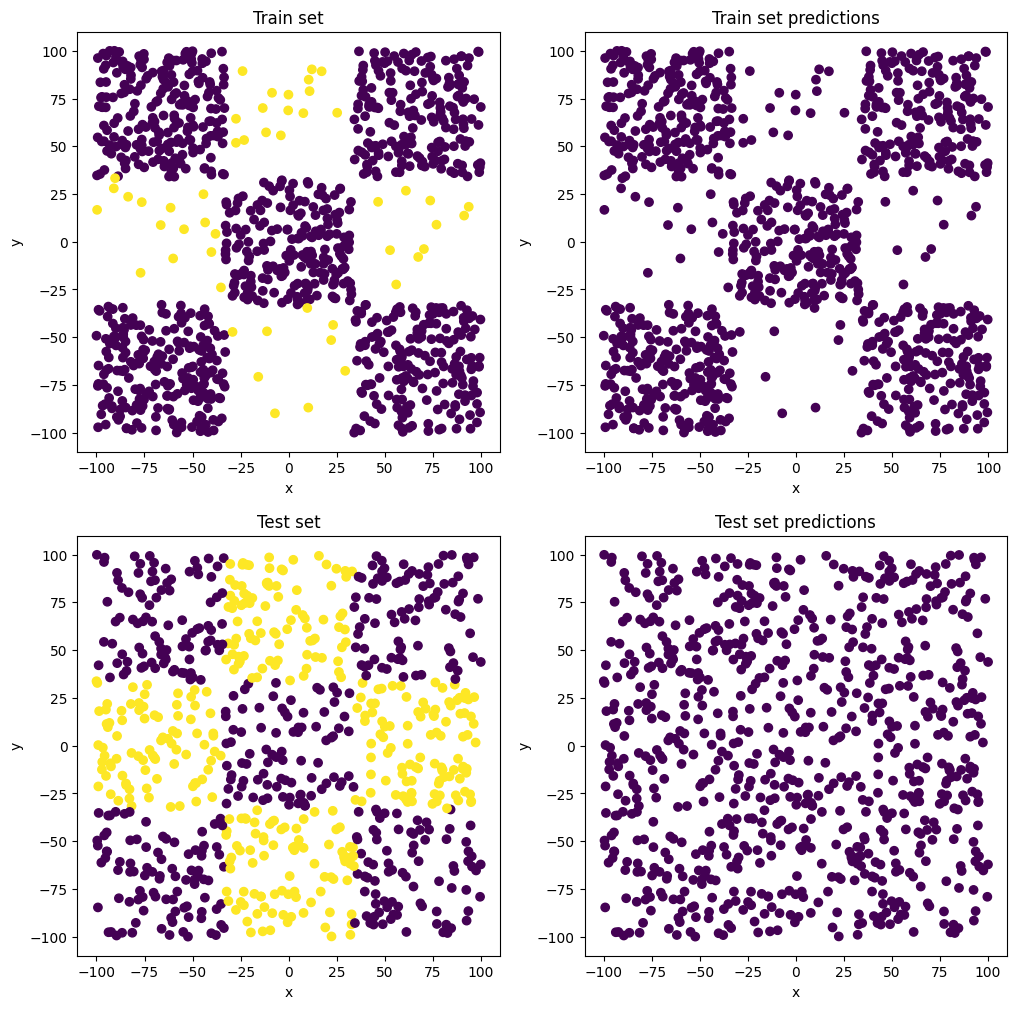

In [406]:
model_standard = copy.deepcopy(model_root)
standard_losses, standard_val_losses = model_standard.fit(X_train_norm, Y_train_norm, X_val=X_test_norm, Y_val=Y_test_norm, 
                                                          first_lr=first_lr, epochs=epochs, n_epochs_displayed=n_epochs_displayed, 
                                                          batch_size=batch_size, track_validation=True, optimizer=optimizer)
plot_results(model_standard, X_train, Y_train, X_test, Y_test)

## L2 regularization

Epoch 1: loss_fun=0.19145239341765855, f1_score=0.4878048780487805
Epoch 100: loss_fun=0.19156652470499136, f1_score=0.4878048780487805
Epoch 200: loss_fun=0.19147031738919779, f1_score=0.4878048780487805
Epoch 300: loss_fun=0.19166489797844813, f1_score=0.4878048780487805
Epoch 400: loss_fun=0.19159107725132518, f1_score=0.4878048780487805
Epoch 500: loss_fun=0.1916037521163291, f1_score=0.4878048780487805
Epoch 600: loss_fun=0.19149433088742918, f1_score=0.4878048780487805
Epoch 700: loss_fun=0.19149394894782337, f1_score=0.4878048780487805
Epoch 800: loss_fun=0.19149861201395574, f1_score=0.4878048780487805
Epoch 900: loss_fun=0.19185147117183568, f1_score=0.4878048780487805
Epoch 1000: loss_fun=0.19149594941873582, f1_score=0.4878048780487805
Epoch 1100: loss_fun=0.1915139709618099, f1_score=0.4878048780487805
Epoch 1200: loss_fun=0.19172150916547148, f1_score=0.4878048780487805
Epoch 1300: loss_fun=0.19146058574987992, f1_score=0.4878048780487805
Epoch 1400: loss_fun=0.19149119419

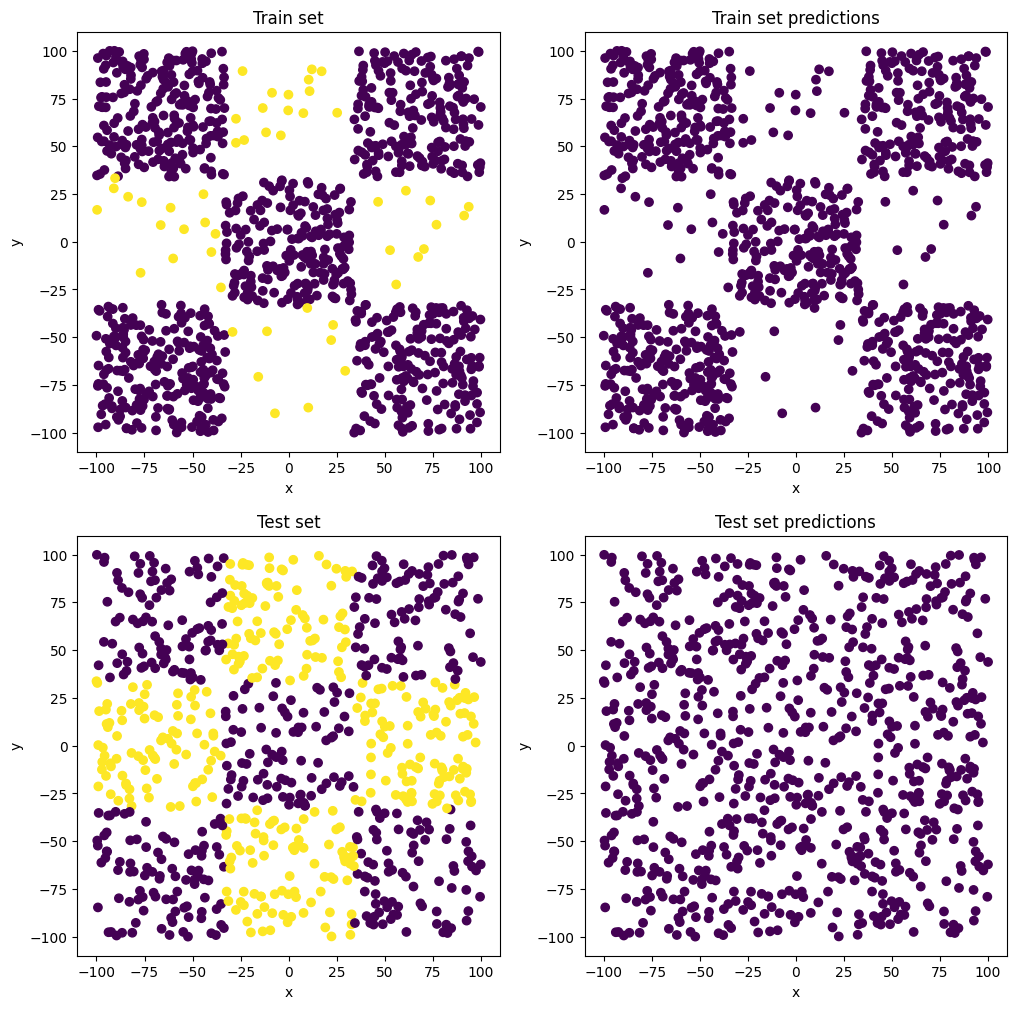

In [407]:
model_l2 = copy.deepcopy(model_root)
l2_losses, l2_val_losses = model_l2.fit(X_train_norm, Y_train_norm, X_val=X_test_norm, Y_val=Y_test_norm, 
                                        first_lr=first_lr, epochs=epochs, n_epochs_displayed=n_epochs_displayed, 
                                        batch_size=batch_size, track_validation=True, l2_reg_coef=0.1, optimizer=optimizer)
plot_results(model_l2, X_train, Y_train, X_test, Y_test)

## Early stopping

Epoch 1: loss_fun=0.19154665737125237, f1_score=0.4878048780487805
Epoch 100: loss_fun=0.19145047769072326, f1_score=0.4878048780487805
Epoch 200: loss_fun=0.1934509061946082, f1_score=0.4878048780487805
Epoch 300: loss_fun=0.1918034842600436, f1_score=0.4878048780487805
Epoch 400: loss_fun=0.19218714305354487, f1_score=0.4878048780487805
Epoch 500: loss_fun=0.19205166246573546, f1_score=0.4878048780487805
Early stopping at epoch 500


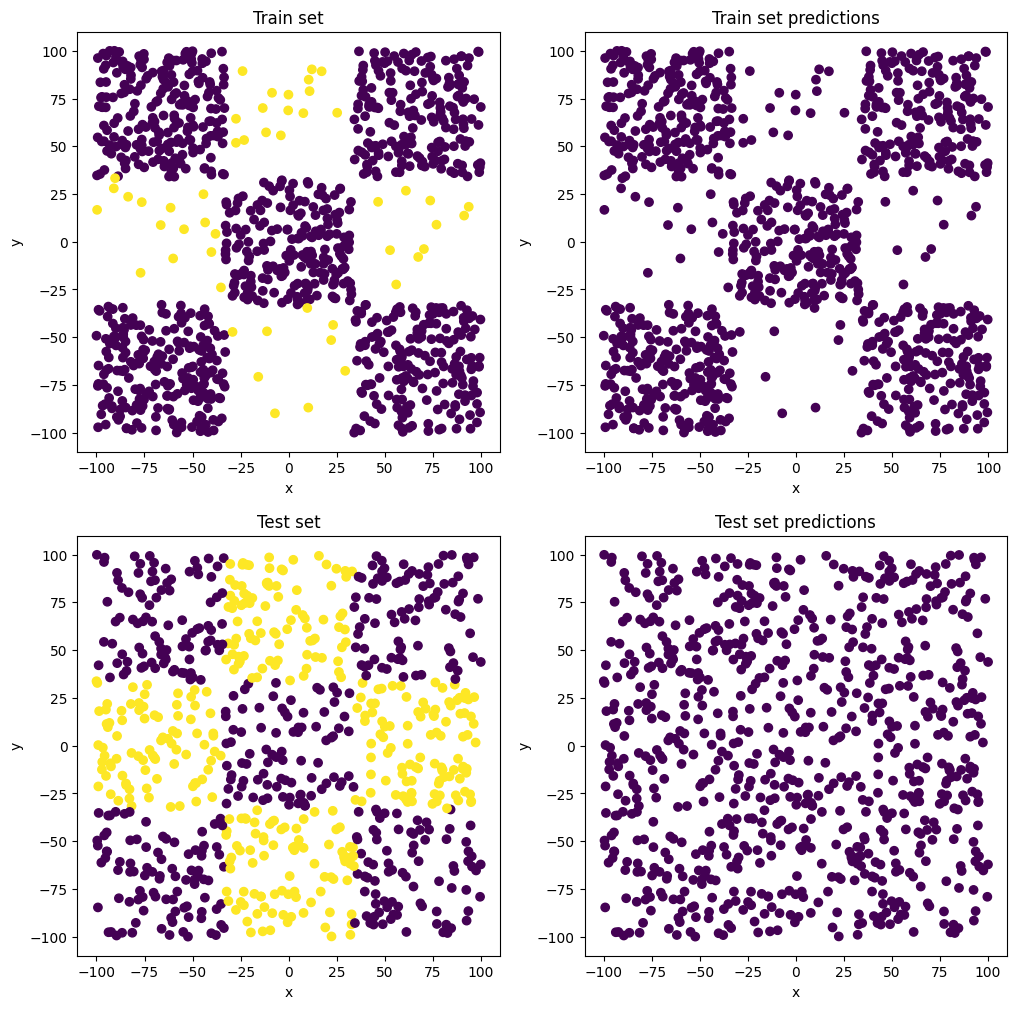

In [408]:
model_stop = copy.deepcopy(model_root)
stop_losses, stop_val_losses = model_stop.fit(X_train_norm, Y_train_norm, X_val=X_test_norm, Y_val=Y_test_norm, 
                                                first_lr=first_lr, epochs=epochs, n_epochs_displayed=n_epochs_displayed, 
                                                batch_size=batch_size, track_validation=True, optimizer=optimizer, patience=500, stopping_min_coef=0.1)
plot_results(model_stop, X_train, Y_train, X_test, Y_test)

## Loss function over epochs dynamic

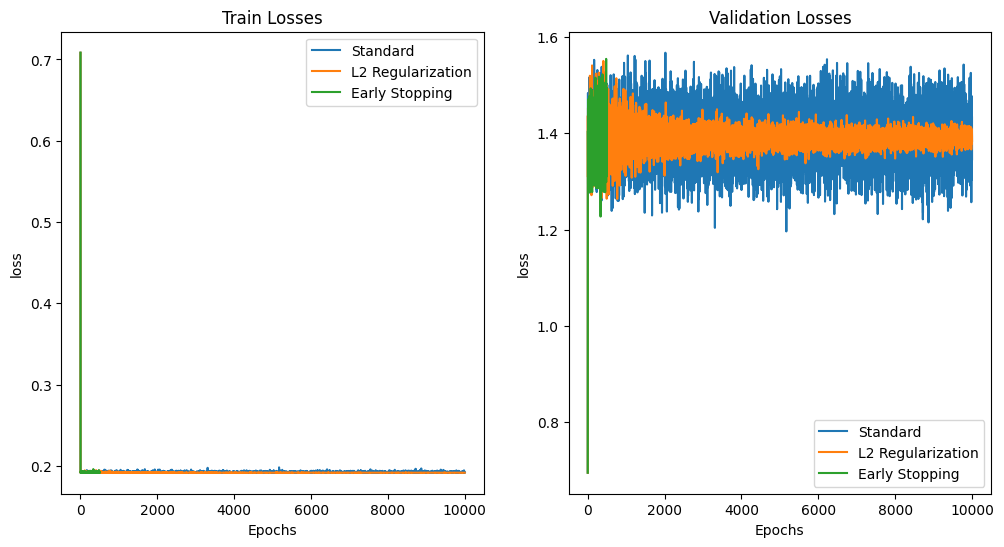

In [409]:
compare_losses(standard_losses, standard_val_losses, l2_losses, l2_val_losses, stop_losses, stop_val_losses, scale_y_log=False)

In [410]:
print('Standard model cross entropy:', model_standard.loss_fun(Y_test_norm, model_standard.predict(X_test_norm, return_probabilities=True)))
print('L2 model cross entropy:', model_l2.loss_fun(Y_test_norm, model_l2.predict(X_test_norm, return_probabilities=True)))
print('Early stopping model cross entropy:', model_stop.loss_fun(Y_test_norm, model_stop.predict(X_test_norm, return_probabilities=True)))
print()
print('Standard model f1 score:', f1_score(Y_test, model_standard.predict(X_test_norm, return_probabilities=False), average="macro"))
print('L2 model f1 score:', f1_score(Y_test, model_l2.predict(X_test_norm, return_probabilities=False), average="macro"))
print('Early stopping model f1 score:', f1_score(Y_test, model_stop.predict(X_test_norm, return_probabilities=False), average="macro"))

Standard model cross entropy: 1.3464414694603273
L2 model cross entropy: 1.3844582789882829
Early stopping model cross entropy: 0.6950323766330352

Standard model f1 score: 0.355877616747182
L2 model f1 score: 0.355877616747182
Early stopping model f1 score: 0.30915371329879104
